# 1. The raw scenario graph

This is exactly the GraphData built in dataset.py before any GNN layers. It has
- Nodes = all the points (agent trajectory points, other objects' points, all the lane centerline points)
- Edges = two kinds:
    - Intra-polyline edges, connecting each node to its successor along the same polyline
    - Inter‐polyline edges, if you used get_fc_edge_index or a KNN threshold to link nearby polylines at the raw level

In [1]:
import dataset
from dataset import GraphData
import __main__
__main__.GraphData = GraphData

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
from dataset import GraphDataset
import os

In [23]:
def plot_scenario_graph(
    dataset_dir: str,
    scenario_idx: int = 0,
    polyline_idx: int = None,
    show_labels: bool = True,
    save_path: str = None,
    node_size: int = 400,
    edge_color: str = 'gray',
    figsize: tuple = (12, 12),
):
    """
    Plots either the full raw graph for one scenario or the subgraph of a single polyline.
    
    Args:
        dataset_dir: path to your INTERMEDIATE_DATA_DIR (e.g. 'interm_data/train_intermediate')
        scenario_idx: which scenario to visualize (0-based)
        polyline_idx: if None, plot the full graph; otherwise plot only cluster == polyline_idx
        show_labels: whether to draw node IDs as labels
        save_path: filename to save the PNG; if None, shows interactively
        node_size: size of each node in the plot
        edge_color: color for all edges
        figsize: figure size in inches
    """
    # 1) Load the single scenario
    dataset = GraphDataset(dataset_dir)
    data = dataset[scenario_idx]
    xyt = data.x[:, :2].cpu().numpy()     # not used for spring_layout
    clusters = data.cluster.cpu().numpy()
    src, dst = data.edge_index.cpu().numpy()

    # 2) Build the NetworkX graph
    G = nx.DiGraph()
    N = data.x.size(0)
    for i in range(N):
        if polyline_idx is None or clusters[i] == polyline_idx:
            G.add_node(i)

    for u, v in zip(src, dst):
        if u in G and v in G:
            G.add_edge(int(u), int(v))

    # 3) Compute spring layout
    pos = nx.spring_layout(G)

    # 4) Draw
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos,
                           node_size=node_size,
                           node_color='skyblue',
                           edgecolors='k')
    nx.draw_networkx_edges(G, pos,
                           edge_color=edge_color,
                           arrows=False)
    if show_labels:
        nx.draw_networkx_labels(G, pos,
                                font_size=8,
                                font_color='black')

    title = f"Scenario {scenario_idx}"
    if polyline_idx is not None:
        title += f" – Polyline {polyline_idx}"
    plt.title(title)
    plt.axis('off')

    # 5) Save or show
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved graph to {save_path}")
    else:
        plt.show()

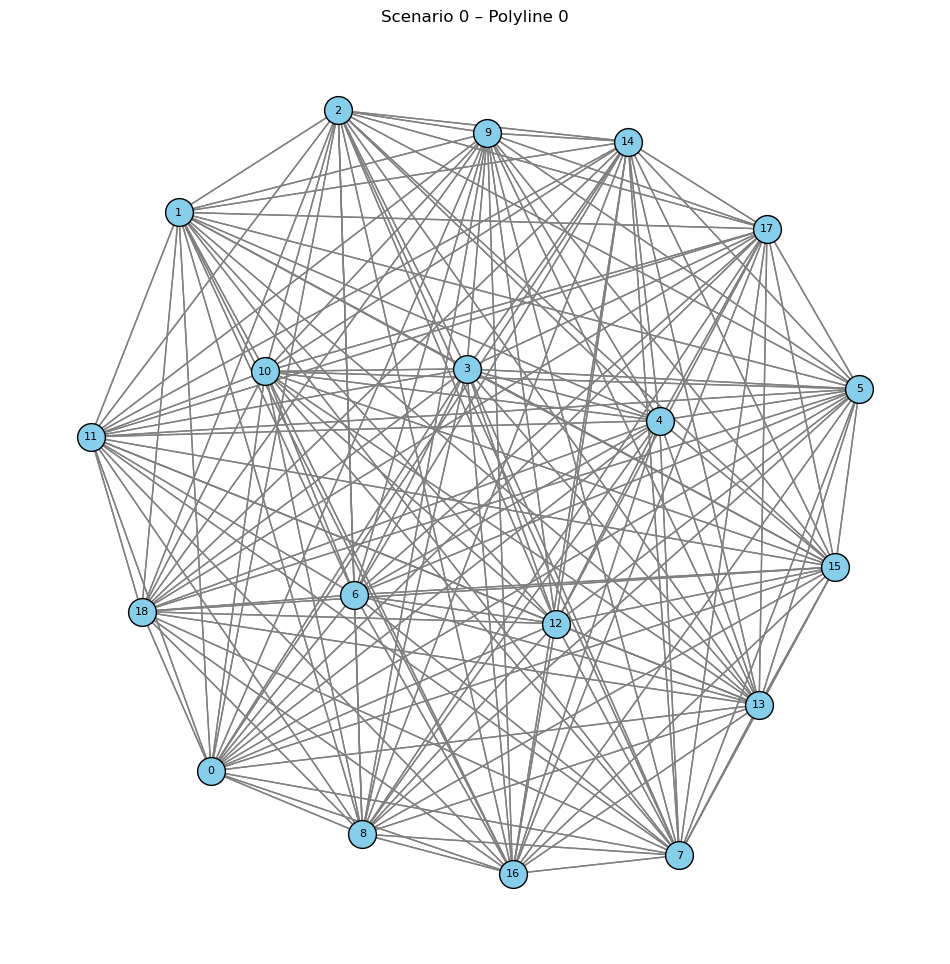

In [24]:
    # # Examples:
    # plot_scenario_graph(
    #     'interm_data/train_intermediate',
    #     scenario_idx=0,
    #     polyline_idx=None,           # full graph
    #     show_labels=True,
    #     # save_path='graphs/scenario0_full.png'
    # )
    plot_scenario_graph(
        'interm_data/train_intermediate',
        scenario_idx=0,
        polyline_idx=0,              # only polyline cluster==5
        show_labels=True,
        # save_path='graphs/scenario0_poly0.png'
    )

In [30]:
from pyvis.network import Network
import torch
from dataset import GraphDataset

def interactive_scenario(dataset_dir, scenario_idx=0, output_html='graph.html'):
    ds = GraphDataset(dataset_dir)
    data = ds[scenario_idx]
    xy = data.x[:, :2].cpu().numpy()
    clusters = data.cluster.cpu().numpy()
    src, dst = data.edge_index.cpu().numpy()

    net = Network(height='750px', width='100%', notebook=False)
    # add nodes
    for i, (x,y) in enumerate(xy):
        net.add_node(i, label=str(i), x=float(x*100), y=float(-y*100),
                     color=f"#{clusters[i]:02x}{(clusters[i]*3)%256:02x}80")
    # add edges
    for u,v in zip(src, dst):
        net.add_edge(int(u), int(v), color='lightgray', width=1)

    net.show(output_html)
    print(f"Interactive graph saved to {output_html}")

In [31]:
# Example
interactive_scenario('interm_data/train_intermediate', 0, 'scenario0.html')

Interactive graph saved to scenario0.html


# 2. Subgraph-level polyline graph

This is after SubGraph module in subgraph.py where we pass graph data into lower level GNN layer to get polyline (subgraph) embedding. Each scenario contains multiple polylines and each polyline contains multiple nodes. SubGraph module takes each scenario and transforms them into subgraphs embeddings, [P, D] where P is number of polylines (subgraphs in the scenario) and D is embedding. It has
- Nodes = number of polylines (subgraphs) where each polyline represent objects whether it's agent, other objects, or lanes
- Edges = fully-connected between nodes as this is passed onto self-attention module

In [7]:
import os
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from dataset import GraphDataset

def plot_polyline_complete_graph(
    dataset_dir: str,
    scenario_idx: int = 0,
    subset_pct: float = 1.0,
    figsize: tuple = (12, 12),
    node_size: int = 300,
    edge_color: str = 'gray',
    cmap: str = 'tab20',
    with_labels: bool = True,
    save_path: str = None,
    spring_iters: int = 50,
    seed: int = 42,
):
    """
    Builds and plots the fully‐connected polyline graph (one node per cluster).
    """
    # 1) Load the scenario
    ds = GraphDataset(dataset_dir)
    data = ds[scenario_idx]
    clusters = data.cluster.cpu().numpy()
    unique = np.unique(clusters)
    P = unique.size

    # 2) sample a subset of clusters if requested
    if subset_pct < 1.0:
        np.random.seed(seed)
        sample_n = max(1, int(P * subset_pct))
        sampled = np.random.choice(unique, size=sample_n, replace=False)
    else:
        sampled = unique
        sample_n = P

    # 3) Build a complete graph on P nodes
    G = nx.complete_graph(sampled)

    # 4) Compute a spring layout
    pos = nx.spring_layout(G, iterations=spring_iters)

    # 5) Draw nodes & edges
    plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)
    node_list = list(G.nodes())
    color_indices = list(range(len(node_list)))
    
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size,
        node_color=color_indices,
        cmap=plt.get_cmap(cmap, len(node_list)),
    )
    if with_labels:
        nx.draw_networkx_labels(G, pos, labels={n: str(n) for n in node_list}, font_size=10)

    plt.title(f"Scenario {scenario_idx}: Complete polyline graph ({len(node_list)} of {P})")
    plt.axis('off')

    # 6) Save or show
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved to {save_path}")
    else:
        plt.show()

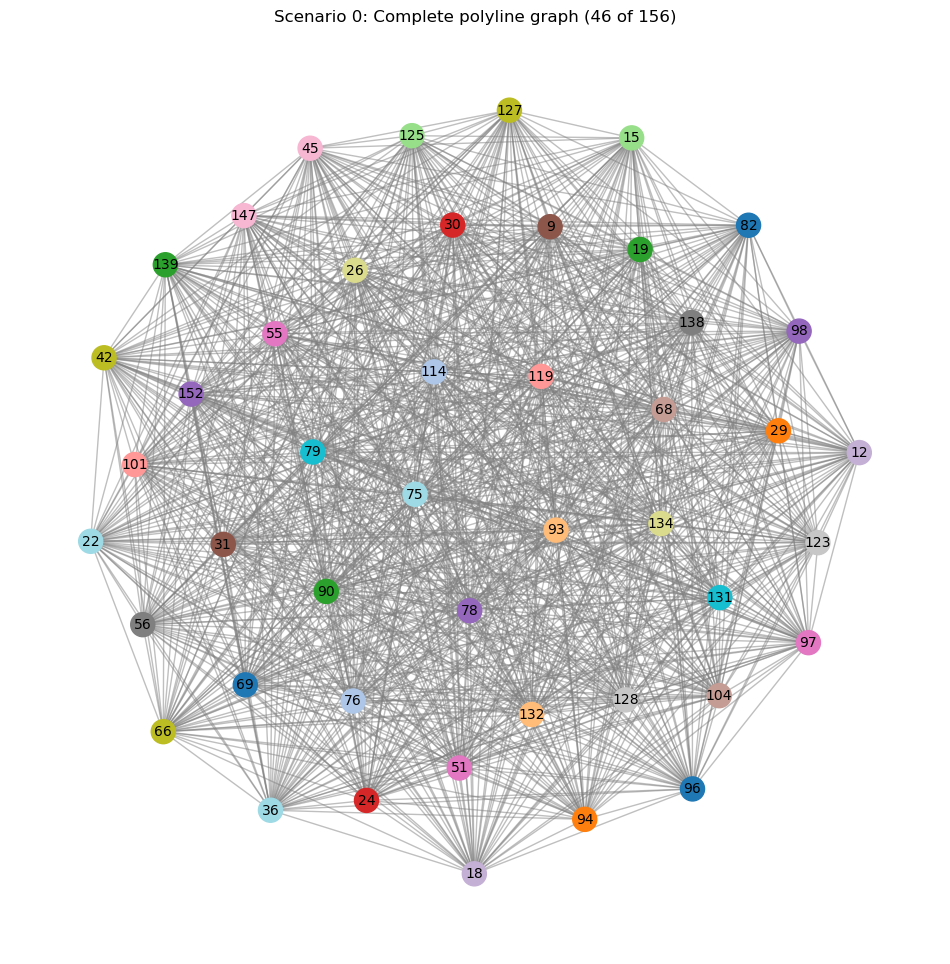

In [9]:
plot_polyline_complete_graph(
    dataset_dir = "interm_data/train_intermediate",
    scenario_idx = 0,
    subset_pct = 0.3,
    # save_path    = "graphs/scenario0_subgraph_level.png"
)

# 3. Scenario plot in map representation

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.viz_utils import show_traj, show_doubled_lane  # :contentReference[oaicite:0]{index=0}

def _unpack_mask(mask):
    """
    Flatten any nested tuple/list/ndarray into two ints: (start, end).
    """
    # flatten
    flat = []
    if isinstance(mask, (list, tuple, np.ndarray)):
        for m in mask:
            if isinstance(m, (list, tuple, np.ndarray)):
                flat.extend(list(m))
            else:
                flat.append(m)
    else:
        flat = [mask]
    if len(flat) < 2:
        raise ValueError(f"Cannot parse mask {mask}")
    return int(flat[0]), int(flat[1])

def plot_scenario_from_pkl(
    pkl_path: str,
    figsize=(8,8),
    show_lane: bool = True,
    save_path: str = None
):
    """
    Plot one full‐5s scenario from its .pkl file instead of rerunning the API.

    pkl must contain columns:
      - 'POLYLINE_FEATURES' : [N_pts, feat_dim]
      - 'TRAJ_ID_TO_MASK'    : dict(track_id→(start,end))
      - 'LANE_ID_TO_MASK'    : dict(lane_id→(start,end))
      - 'TARJ_LEN'           : int number of trajectory points
    """
    # 1) Load the single‐row DataFrame
    df = pd.read_pickle(pkl_path)
    feats     = df['POLYLINE_FEATURES'].iloc[0]  # :contentReference[oaicite:1]{index=1}
    traj_mask = df['TRAJ_ID_TO_MASK'].iloc[0]
    lane_mask = df['LANE_ID_TO_MASK'].iloc[0]
    add_len   = int(df['TARJ_LEN'].iloc[0])

    # 2) Reconstruct polylines
    traj_ls, lane_ls = [], []
    for tid, mask in traj_mask.items():
        s, e = _unpack_mask(mask)
        data = feats[s:e]
        # stack start‐points and final end‐point
        traj = np.vstack((data[:,0:2], data[-1,2:4]))
        traj_ls.append(traj)

    for lid, mask in lane_mask.items():
        s, e = _unpack_mask(mask)
        data = feats[s+add_len : e+add_len]
        lane = np.vstack((data[:,0:2], data[-1,2:4]))
        lane_ls.append(lane)

    # 3) Plotting
    fig, ax = plt.subplots(figsize=figsize)
    # 3a) lanes
    if show_lane:
        for lane in lane_ls:
            show_doubled_lane(lane)  # gray dashed centerlines :contentReference[oaicite:2]{index=2}

    # 3b) agent + others
    for i, traj in enumerate(traj_ls):
        if i == 0:
            # ego in red dashed + empty circles
            ax.plot( traj[:,0], traj[:,1], '--', color='red', lw=2, label='Ego' )
            ax.scatter( traj[:,0], traj[:,1],
                        facecolors='none', edgecolors='red', s=60 )
        else:
            # other vehicles dotted + empty circles
            ax.plot( traj[:,0], traj[:,1], ':', lw=1, label='_nolegend_' )
            ax.scatter( traj[:,0], traj[:,1],
                        facecolors='none', edgecolors='C{}'.format((i-1)%10), s=40 )

    # 4) Final style
    ax.set_aspect('equal', 'box')
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend(loc='upper right', fontsize='small')
    title_number = pkl_path.split('/')[-1].split('.')[0].split('_')[-1]
    ax.set_title(f'Scenario {title_number}')

    # 5) Save or show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Saved to {save_path}")
    else:
        plt.show()


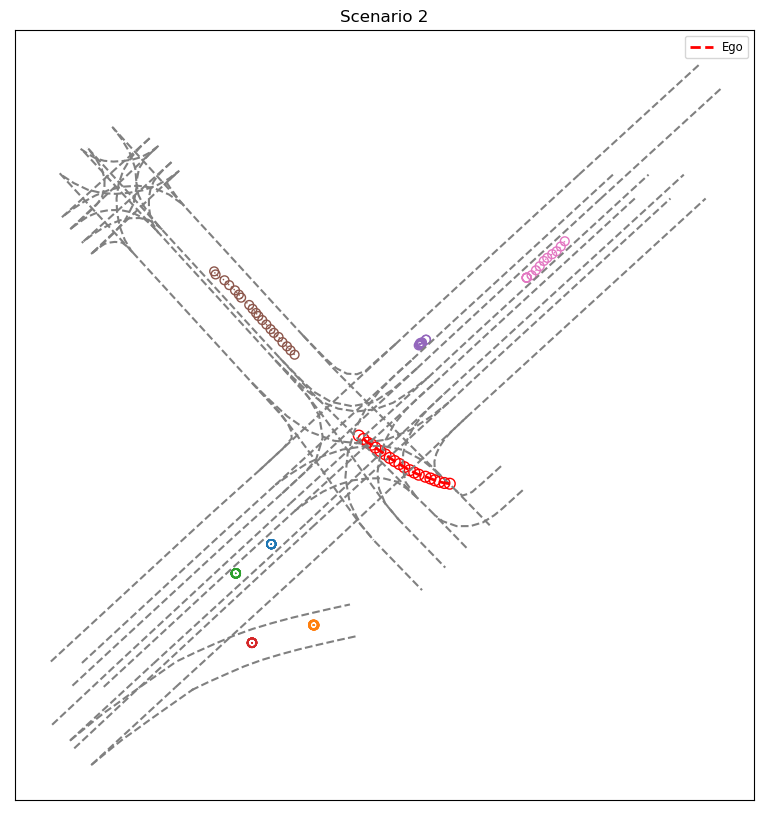

In [32]:
plot_scenario_from_pkl(
    pkl_path="interm_data/train_intermediate/features_2.pkl",
    figsize=(10,10),
    show_lane=True,
    # save_path="graphs/scenario_2_map.png"
)


# 3. Loss Visualization

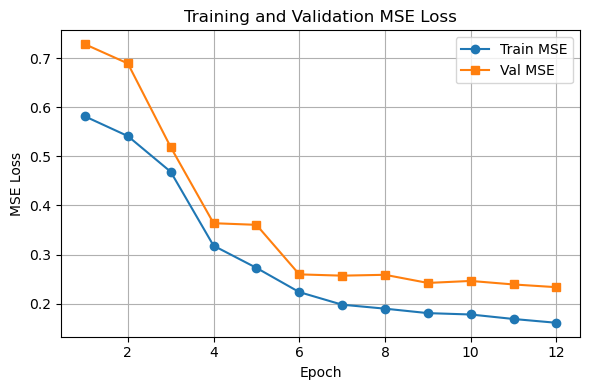

In [13]:
import json
import matplotlib.pyplot as plt

# 1) Load your history
history_path = 'trained_params/loss_history.json'
with open(history_path, 'r') as f:
    history = json.load(f)

train_loss = history.get('train_mse', [])
val_loss   = history.get('val_mse',   [])
minADE     = history.get('val_minADE', [])
minFDE     = history.get('val_minFDE', [])

# Previous epoch loss history.json was not saved, but logging in .txt exists. Used log .txt file for complete loss graph.
# I can provide evidence if needed.
train_loss_epoch1to4 = [0.581627, 0.541468, 0.468699, 0.318015]
val_loss_epoch1to4 = [0.728649, 0.689533, 0.518995, 0.363859]
val_minADE_epoch1to4 = [15.701759, 14.989095, 12.500567, 10.040519]
val_minFDE_epoch1to4 = [29.873514, 28.500872, 23.720315, 18.921536]

train_loss = train_loss_epoch1to4 + train_loss
val_loss = val_loss_epoch1to4 + val_loss
minADE = val_minADE_epoch1to4 + minADE
minFDE = val_minFDE_epoch1to4 + minFDE

epochs = list(range(1, len(train_loss) + 1))

# 2) Plot MSE Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, marker='o')
if val_loss:
    plt.plot(epochs, val_loss, marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss')
plt.legend(['Train MSE'] + (['Val MSE'] if val_loss else []))
plt.grid(True)
plt.tight_layout()
plt.savefig('graphs/MSE_loss.png', dpi=300)
plt.show()

# 4. Evaluation Metrics

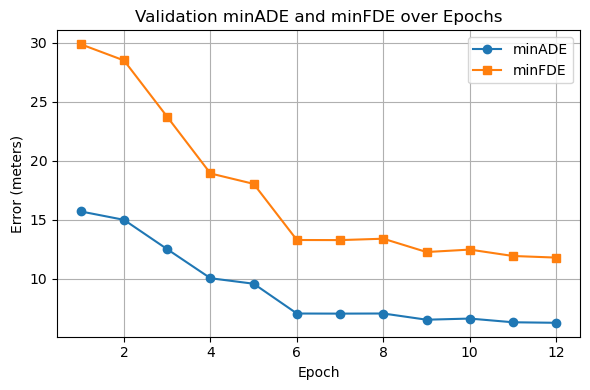

In [14]:
# 3) Plot minADE & minFDE
plt.figure(figsize=(6, 4))
plt.plot(epochs[:len(minADE)], minADE, marker='o')
plt.plot(epochs[:len(minFDE)], minFDE, marker='s')
plt.xlabel('Epoch')
plt.ylabel('Error (meters)')
plt.title('Validation minADE and minFDE over Epochs')
plt.legend(['minADE', 'minFDE'])
plt.grid(True)
plt.tight_layout()
plt.savefig('graphs/metrics.png', dpi=300)
plt.show()

In [69]:
import os
import glob
import torch
from dataset import GraphDataset
from modeling.vectornet import HGNN
from torch_geometric.data import Batch

In [79]:
INTERM_DIR = "interm_data/train_intermediate/"   # folder with your .pkl’s
CHECKPOINT = "trained_params/best_epoch_12_ADE_6.2626.pth"
SCENARIO_IDX = 0   # e.g. the 124th .pkl in your folder
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
model = HGNN(
    in_channels = 8,
    future_steps = 30,
    num_subgraph_layers = 3,
    subgraph_hidden = 64,
    global_hidden = 64,
    mlp_hidden = 64,
    need_scale = True
).to(DEVICE)
ckpt = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(ckpt['model'])
model.eval()

HGNN(
  (subgraph): SubGraph(
    (layers): ModuleList(
      (0): GraphLayerProp()
      (1): GraphLayerProp()
      (2): GraphLayerProp()
    )
  )
  (global_net): SelfAttentionLayer(
    (q_lin): Linear(in_features=64, out_features=64, bias=True)
    (k_lin): Linear(in_features=64, out_features=64, bias=True)
    (v_lin): Linear(in_features=64, out_features=64, bias=True)
  )
  (traj_pred): TrajPredMLP(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=60, bias=True)
    )
  )
)

In [80]:
ds = GraphDataset(INTERM_DIR)
data = ds[SCENARIO_IDX].to(DEVICE)

In [81]:
batch = Batch.from_data_list([ data ]).to(DEVICE)
with torch.no_grad():
    pred = model(batch)
pred = pred[0].numpy()

In [88]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.viz_utils import show_doubled_lane

def _unpack_mask(mask):
    flat = []
    if isinstance(mask, (list, tuple, np.ndarray)):
        for m in mask:
            if isinstance(m, (list, tuple, np.ndarray)):
                flat.extend(list(m))
            else:
                flat.append(m)
    else:
        flat = [mask]
    if len(flat) < 2:
        raise ValueError(f"Cannot parse mask {mask}")
    return int(flat[0]), int(flat[1])

def plot_pred_vs_gt_from_pkl(
    pkl_path: str,
    preds: np.ndarray,
    figsize=(8,8),
    show_lane: bool = True,
    save_path: str = None
):
    """
    pkl must contain:
      - 'POLYLINE_FEATURES' : [N_pts, feat_dim]
      - 'TRAJ_ID_TO_MASK'    : dict(track_id→(start,end))
      - 'LANE_ID_TO_MASK'    : dict(lane_id→(start,end))
      - 'TARJ_LEN'           : int # obs points (e.g. 20)
      - 'OFFSET_GT'          : [F,2] ground‐truth offsets
    preds can be shape (2*F,) or (F,2) predicted offsets.
    """
    # 1) Load
    df = pd.read_pickle(pkl_path)
    feats = df['POLYLINE_FEATURES'].iloc[0]
    traj_mask = df['TRAJ_ID_TO_MASK'].iloc[0]
    lane_mask = df['LANE_ID_TO_MASK'].iloc[0]
    obs_len = int(df['TARJ_LEN'].iloc[0])
    offset_gt = np.array(df['GT'].iloc[0])

    # 2) Reshape GT offsets
    if offset_gt.ndim == 1:
        offset_gt = offset_gt.reshape(-1, 2)
    F = offset_gt.shape[0]

    # 3) Reconstruct agent history
    s, e = _unpack_mask(traj_mask[0])
    data = feats[s:e]
    agent_hist = np.vstack((data[:,0:2], data[-1,2:4]))  # (obs_len+1,2)
    hist_end = agent_hist[-1]

    # 4) Compute GT future positions
    gt_future = np.cumsum(offset_gt, axis=0) + hist_end  # (F,2)

    # 5) Reshape preds → (F,2)
    p = np.array(preds)
    if p.ndim == 1:
        p = p.reshape(-1, 2)
    pred_future = np.cumsum(p, axis=0) + hist_end

    # 6) Plot
    fig, ax = plt.subplots(figsize=figsize)
    if show_lane:
        for mask in lane_mask.values():
            s2,e2 = _unpack_mask(mask)
            ldata = feats[s2+obs_len : e2+obs_len]
            lane = np.vstack((ldata[:,0:2], ldata[-1,2:4]))
            show_doubled_lane(lane) 

    # History
    ax.plot(agent_hist[:,0], agent_hist[:,1], '-k', lw=2, label='History')
    ax.scatter(agent_hist[:,0], agent_hist[:,1], facecolors='none', edgecolors='k', s=40)

    # Ground truth future
    ax.plot(gt_future[:,0], gt_future[:,1], '-g', lw=2, label='GT Future')
    if F>=2:
        ax.annotate('', xy=gt_future[-1], xytext=gt_future[-2],
                    arrowprops=dict(arrowstyle='->', color='green', lw=2))

    # Predicted future
    ax.plot(pred_future[:,0], pred_future[:,1], '--m', lw=2, label='Pred Future')
    if F>=2:
        ax.annotate('', xy=pred_future[-1], xytext=pred_future[-2],
                    arrowprops=dict(arrowstyle='->', color='magenta', lw=2))

    ax.set_aspect('equal','box')
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend(loc='upper right', fontsize='small')
    title_number = os.path.basename(pkl_path).split('_')[-1].split('.')[0]
    ax.set_title(f'Scenario {title_number}')

    # Save or show
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Saved to {save_path}")
    else:
        plt.show()


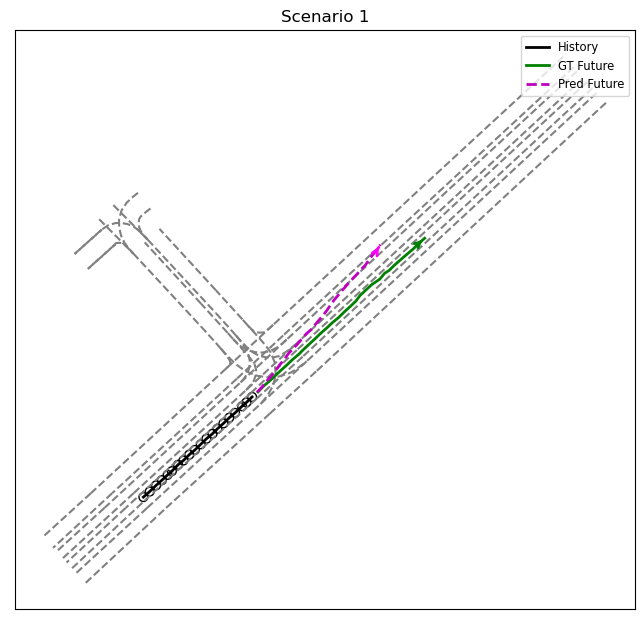

In [89]:
# Suppose `preds` is your model’s output for this scenario, shape (60,) or (30,2)
plot_pred_vs_gt_from_pkl(
    pkl_path="interm_data/train_intermediate/features_1.pkl",
    preds    = pred, 
    # save_path="graphs/scenario1_pred_vs_gt.png"
)
